In [4]:
using NRIRHOPM, FileIO, Images, Plots, Interpolations, Memento; gr()

Plots.GRBackend()

In [5]:
import NRIRHOPM: constrain!

In [6]:
include("draw2.jl")

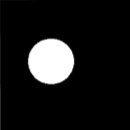

In [7]:
circle = Gray.(load("./circle.png"))

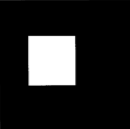

In [8]:
square = Gray.(load("./squarec.png"))

In [9]:
size(circle), size(square), typeof(circle)

((130,130),(130,129),Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2})

In [10]:
square, circle = restrict(square), restrict(circle); 

In [11]:
fixed, moving = square[1:64,1:64],  circle[1:64,1:64];

In [12]:
function hopm_mixed2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝐌::AbstractMatrix, constraint::Symbol, tol::Real, maxIter::Integer, b::Float64)
    𝐌₀ = copy(𝐌)
    constrain!(𝐌₀, constraint)
    𝐌ᵢ = 𝐌₀
    i = 0
    while i < maxIter
        i += 1
        𝐌ᵢ₊₁ = 𝐭 + b*(𝐓 ⊙ 𝐌ᵢ)
        constrain!(𝐌ᵢ₊₁, constraint)
        if vecnorm(𝐌ᵢ₊₁ - 𝐌ᵢ) < tol
            𝐌ᵢ = 𝐌ᵢ₊₁
            break
        end
        𝐌ᵢ = 𝐌ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, HOPM might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return sum(𝐌ᵢ .* (𝐭 + b*(𝐓 ⊙ 𝐌ᵢ))), 𝐌ᵢ
end

function hopm_mixed2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝑻::BlockedTensor, 𝐌::AbstractMatrix, constraint::Symbol, tol::Real, maxIter::Integer, b::Float64, c::Float64)
    𝐌₀ = copy(𝐌)
    constrain!(𝐌₀, constraint)
    𝐌ᵢ = 𝐌₀
    i = 0
    while i < maxIter
        i += 1
        𝐌ᵢ₊₁ = 𝐭 + b*(𝐓 ⊙ 𝐌ᵢ) + c*(𝑻 ⊙ 𝐌ᵢ)
        constrain!(𝐌ᵢ₊₁, constraint)
        if vecnorm(𝐌ᵢ₊₁ - 𝐌ᵢ) < tol
            𝐌ᵢ = 𝐌ᵢ₊₁
            break
        end
        𝐌ᵢ = 𝐌ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, HOPM might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return sum(𝐌ᵢ .* (𝐭 + b*(𝐓 ⊙ 𝐌ᵢ) + c*(𝑻 ⊙ 𝐌ᵢ))), 𝐌ᵢ
end

hopm_mixed2 (generic function with 2 methods)

In [13]:
immutable MixHOPM2{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    constraint::Symbol
    tolerance::Tt
    maxIteration::Tm
    a::Float64
end
MixHOPM2(constraint, tolerance, maxIteration,a) = MixHOPM2(hopm_mixed2, constraint, tolerance, maxIteration,a)
MixHOPM2(;constraint=:vecnorm, tolerance=1e-5, maxIteration=300,a=1) = MixHOPM2(constraint, tolerance, maxIteration,a)

immutable MixHOPM3{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    constraint::Symbol
    tolerance::Tt
    maxIteration::Tm
    a::Float64
    b::Float64
end
MixHOPM3(constraint, tolerance, maxIteration,a,b) = MixHOPM3(hopm_mixed2, constraint, tolerance, maxIteration,a,b)
MixHOPM3(;constraint=:vecnorm, tolerance=1e-5, maxIteration=300,a=1,b=1) = MixHOPM3(constraint, tolerance, maxIteration,a,b)

MixHOPM3{F<:Function,Tt<:Real,Tm<:Integer}

In [57]:
# displacements = [SVector(i,j) for i in -3:3, j in -3:3]
# displacements2 = [SVector(i,j) for i in -1:1, j in -1:1]
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo,displacetopo]#, displacements, displacements2]
gridSet = [(32,32),(32,32)] #,(64,64),(128,128)]
originΔ = vecnorm(moving-fixed)
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=1, χ=0, method=MixHOPM2(maxIteration=50,a=3.))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-02-26T00:05:56 | info ]: Start multilevel processing...
[ 2017-02-26T00:05:56 | info ]: Level 1: 
[ 2017-02-26T00:05:56 | info ]: Image Dimension: (64,64)
[ 2017-02-26T00:05:57 | info ]: Grid Dimension: (32,32)
[ 2017-02-26T00:05:57 | info ]: Creating data cost with weight=1: 
[ 2017-02-26T00:05:57 | info ]:   0.349547 seconds (2.89 M allocations: 81.664 MB, 9.13% gc time)
[ 2017-02-26T00:05:57 | info ]: Creating smooth cost with weight=1: 
[ 2017-02-26T00:05:57 | info ]:   0.000413 seconds (34 allocations: 167.172 KB)
[ 2017-02-26T00:05:57 | info ]: Optimizing via High Order Power Method: 
[ 2017-02-26T00:05:57 | info ]: HOPM converges in 6 steps.
[ 2017-02-26T00:05:57 | info ]:   0.308467 seconds (2.28 k allocations: 19.669 MB, 1.55% gc time)
[ 2017-02-26T00:05:57 | info ]: Multilevel processing done!


1.9162937780589209

In [53]:
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo]
gridSet = [(32,32)]
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=1, χ=1, method=MixHOPM3(maxIteration=50,a=4.,b=4.))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-02-25T23:59:41 | info ]: Start multilevel processing...
[ 2017-02-25T23:59:41 | info ]: Level 0: 
[ 2017-02-25T23:59:41 | info ]: Image Dimension: (64,64)
[ 2017-02-25T23:59:41 | info ]: Grid Dimension: (32,32)
[ 2017-02-25T23:59:41 | info ]: Creating data cost with weight=1: 
[ 2017-02-25T23:59:41 | info ]:   0.336404 seconds (2.89 M allocations: 81.664 MB, 8.36% gc time)
[ 2017-02-25T23:59:41 | info ]: Creating smooth cost with weight=1: 
[ 2017-02-25T23:59:41 | info ]:   0.000373 seconds (34 allocations: 167.172 KB)
[ 2017-02-25T23:59:41 | info ]: Creating topology cost with weight=1: 
[ 2017-02-25T23:59:41 | info ]:   0.025558 seconds (97 allocations: 7.373 MB)
[ 2017-02-25T23:59:41 | info ]: Optimizing via High Order Power Method: 
[ 2017-02-26T00:03:44 | warn ]: Maximum iterator number is reached, HOPM might not be convergent.
[ 2017-02-26T00:03:49 | info ]: 247.850495 seconds (4.79 k allocations: 352.420 MB, 0.03% gc time)
[ 2017-02-26T00:03:49 | info ]: Multilevel proces

1.6445777566724635

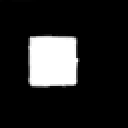

In [54]:
colorview(Gray, warpped[1])

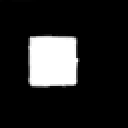

In [55]:
colorview(Gray, warpped[end])

In [58]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # a=3 only

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,280.189 21.7148,275.426 21.7148,270.663 21.7148,265.9 21.7148,265.522 21.7148,265.446 21.7148,261.137 21.7148,256.374 21.7148,251.611 
 21.7148,246.848 21.7148,242.085 21.7148,237.322 21.7148,232.559 21.7148,227.796 21.7148,223.033 21.7148,218.27 21.7148,213.507 21.7148,208.744 21.7148,203.981 
 21.7148,199.219 21.7148,194.456 21.7148,189.693 21.7148,184.93 21.7148,180.167 21.7148,175.404 21.7148,170.641 21.7148,165.878 21.7148,161.115 21.7148,156.352 
 21.7148,151.589 21.7148,146.826 21.7148,142.063 21.7148,137.3 21.7148,132.537 21.7148,127.774 21.7148,123.011 21.7148,118.248 21.7148,113.485 21.7148,108.722 
 21.7148,103.959 21.7148,99.1963 21.7148,94.4333 21.7148,89.6704 21.7148,84.9074 21.7148,80.1444 21.7148,75.3815 21.7148,70.6185 21.7148,65.8555 21.7148,61.0926 
 21.7148,56.3296 21.7148,51.5666 21.7148,46.8037 21.7148,42.0407 21.7148,37.2778 21.7148,32.5148 21.7148,27.7518 21.7148,23.4425 21.7148,23.3669 21.7148,22.9889 
 21.7148,18.2259 21.7148,13.4629 21.7148,8.69997 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,284.952 26.3648,280.189 26.3648,275.426 26.3648,270.663 26.3648,265.9 26.3648,265.522 26.3648,265.446 26.3648,261.137 26.3648,256.374 26.3648,251.611 
 26.3648,246.848 26.3648,242.085 26.3648,237.322 26.3648,232.559 26.3648,227.796 26.3648,223.033 26.3648,218.27 26.3648,213.507 26.3648,208.744 26.3648,203.981 
 26.3648,199.219 26.3648,194.456 26.3648,189.693 26.3648,184.93 26.3648,180.167 26.3648,175.404 26.3648,170.641 26.3648,165.878 26.3648,161.115 26.3648,156.352 
 26.3648,151.589 26.3648,146.826 26.3648,142.063 26.3648,137.3 26.3648,132.537 26.3648,127.774 26.3648,123.011 26.3648,118.248 26.3648,113.485 26.3648,108.722 
 26.3648,103.959 26.3648,99.1963 26.3648,94.4333 26.3648,89.6704 26.3648,84.9074 26.3648,80.1444 26.3648,75.3815 26.3648,70.6185 26.3648,65.8555 26.3648,61.0926 
 26.3648,56.3296 26.3648,51.5666 26.3648,46.8037 26.3648,42.0407 26.3648,37.2778 26.3648,32.5148 26.3648,27.7518 26.3648,23.4425 26.3648,23.3669 26.3648,22.9889 
 26.3648,18.2259 26.3648,13.4629 26.3648,8.69997 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,284.952 31.0147,280.189 31.0147,275.426 31.0147,270.663 31.0147,265.9 31.0147,265.522 31.0147,265.446 31.0147,261.137 31.0147,256.374 31.0147,251.611 
 31.0147,246.848 31.0147,242.085 31.0147,237.322 31.0147,232.559 31.0147,227.796 31.0147,223.033 31.0147,218.27 31.0147,213.507 31.0147,208.744 31.0147,203.981 
 31.0147,199.219 31.0147,194.456 31.0147,189.693 31.0147,184.93 31.0147,180.167 31.0147,175.404 31.0147,170.641 31.0147,165.878 31.0147,161.115 31.0147,156.352 
 31.0147,151.589 31.0147,146.826 31.0147,142.063 31.0147,137.3 31.0147,132.537 31.0147,127.774 31.0147,123.011 31.0147,118.248 31.0147,113.485 31.0147,108.722 
 31.0147,103.959 31.0147,99.1963 31.0147,94.4333 31.0147,89.6704 31.0147,84.9074 31.0147,80.1444 31.0147,75.3815 31.0147,70.6185 31.0147,65.8555 31.0147,61.0926 
 31.0147,56.3296 31.0147,51.5666 31.0147,46.8037 31.0147,42.0407 31.0147,37.2778 31.0147,32.5148 31.0147,27.7518 31.0147,23.4425 31.0147,23.3669 31.0147,22.9889 
 31.0147,18.2259 31.0147,13.4629 31.0147,8.69997 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,284.952 35.6647,280

In [56]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # a=3. b = 3

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 1 
 
 
 5 
 
 
 10 
 
 
 14 
 
 
 18 
 
 
 23 
 
 
 27 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 45 
 
 
 49 
 
 
 53 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,275.811 21.7148,266.671 21.7148,261.918 21.7148,257.311 21.7148,256.945 21.7148,256.872 21.7148,252.704 21.7148,248.097 21.7148,243.491 
 21.7148,238.884 21.7148,234.277 21.7148,229.67 21.7148,225.063 21.7148,220.457 21.7148,215.85 21.7148,211.243 21.7148,206.636 21.7148,202.029 21.7148,197.423 
 21.7148,192.816 21.7148,188.209 21.7148,183.602 21.7148,178.995 21.7148,174.389 21.7148,169.782 21.7148,165.175 21.7148,160.568 21.7148,155.961 21.7148,151.355 
 21.7148,146.748 21.7148,142.141 21.7148,137.534 21.7148,132.927 21.7148,128.321 21.7148,123.714 21.7148,119.107 21.7148,114.5 21.7148,109.893 21.7148,105.287 
 21.7148,100.68 21.7148,96.073 21.7148,91.4662 21.7148,86.8594 21.7148,82.2526 21.7148,77.6458 21.7148,73.039 21.7148,68.4322 21.7148,63.8254 21.7148,59.2186 
 21.7148,54.6118 21.7148,50.005 21.7148,45.3982 21.7148,40.7914 21.7148,36.1846 21.7148,31.5778 21.7148,26.971 21.7148,22.803 21.7148,22.7298 21.7148,22.3642 
 21.7148,17.7574 21.7148,13.1506 21.7148,8.54381 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,280.418 26.3648,273.509 26.3648,266.599 26.3648,261.918 26.3648,257.311 26.3648,256.945 26.3648,256.872 26.3648,252.704 26.3648,248.097 26.3648,243.491 
 26.3648,238.884 26.3648,234.277 26.3648,229.67 26.3648,225.063 26.3648,220.457 26.3648,215.85 26.3648,211.243 26.3648,206.636 26.3648,202.029 26.3648,197.423 
 26.3648,192.816 26.3648,188.209 26.3648,183.602 26.3648,178.995 26.3648,174.389 26.3648,169.782 26.3648,165.175 26.3648,160.568 26.3648,155.961 26.3648,151.355 
 26.3648,146.748 26.3648,142.141 26.3648,137.534 26.3648,132.927 26.3648,128.321 26.3648,123.714 26.3648,119.107 26.3648,114.5 26.3648,109.893 26.3648,105.287 
 26.3648,100.68 26.3648,96.073 26.3648,91.4662 26.3648,86.8594 26.3648,82.2526 26.3648,77.6458 26.3648,73.039 26.3648,68.4322 26.3648,63.8254 26.3648,59.2186 
 26.3648,54.6118 26.3648,50.005 26.3648,45.3982 26.3648,40.7914 26.3648,36.1846 26.3648,31.5778 26.3648,26.971 26.3648,22.803 26.3648,22.7298 26.3648,22.3642 
 26.3648,17.7574 26.3648,13.1506 26.3648,8.54381 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,275.885 31.0147,271.206 31.0147,266.527 31.0147,261.918 31.0147,257.311 31.0147,256.945 31.0147,256.872 31.0147,252.704 31.0147,248.097 31.0147,243.491 
 31.0147,238.884 31.0147,234.277 31.0147,229.67 31.0147,225.063 31.0147,220.457 31.0147,215.85 31.0147,211.243 31.0147,206.636 31.0147,202.029 31.0147,197.423 
 31.0147,192.816 31.0147,188.209 31.0147,183.602 31.0147,178.995 31.0147,174.389 31.0147,169.782 31.0147,165.175 31.0147,160.568 31.0147,155.961 31.0147,151.355 
 31.0147,146.748 31.0147,142.141 31.0147,137.534 31.0147,132.927 31.0147,128.321 31.0147,123.714 31.0147,119.107 31.0147,114.5 31.0147,109.893 31.0147,105.287 
 31.0147,100.68 31.0147,96.073 31.0147,91.4662 31.0147,86.8594 31.0147,82.2526 31.0147,77.6458 31.0147,73.039 31.0147,68.4322 31.0147,63.8254 31.0147,59.2186 
 31.0147,54.6118 31.0147,50.005 31.0147,45.3982 31.0147,40.7914 31.0147,36.1846 31.0147,31.5778 31.0147,26.971 31.0147,22.803 31.0147,22.7298 31.0147,22.3642 
 31.0147,17.7574 31.0147,13.1506 31.0147,8.54381 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,275.738 35.6647,271.131 35.6647

In [52]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # a=1. b = 3

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 12 
 
 
 16 
 
 
 20 
 
 
 25 
 
 
 29 
 
 
 34 
 
 
 38 
 
 
 42 
 
 
 47 
 
 
 51 
 
 
 55 
 
 
 60 
 
 
 64 
 
 
 1 
 
 
 6 
 
 
 10 
 
 
 14 
 
 
 19 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 55 
 
 
 60 
 
 
 64 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,276.102 21.7148,267.251 21.7148,262.649 21.7148,258.189 21.7148,257.835 21.7148,257.764 21.7148,257.693 21.7148,257.622 21.7148,249.905 
 21.7148,241.054 21.7148,235.886 21.7148,231.425 21.7148,226.965 21.7148,222.504 21.7148,218.044 21.7148,213.583 21.7148,209.122 21.7148,204.662 21.7148,200.201 
 21.7148,195.741 21.7148,191.28 21.7148,186.82 21.7148,182.359 21.7148,177.899 21.7148,173.438 21.7148,168.977 21.7148,164.517 21.7148,160.056 21.7148,155.596 
 21.7148,151.135 21.7148,146.675 21.7148,142.214 21.7148,137.754 21.7148,133.293 21.7148,128.833 21.7148,124.372 21.7148,119.911 21.7148,115.451 21.7148,110.99 
 21.7148,106.53 21.7148,102.069 21.7148,97.6086 21.7148,93.1481 21.7148,88.6875 21.7148,84.227 21.7148,79.7664 21.7148,75.3059 21.7148,70.8453 21.7148,66.3848 
 21.7148,61.9242 21.7148,57.4637 21.7148,53.0031 21.7148,47.8345 21.7148,38.9842 21.7148,31.2667 21.7148,31.1959 21.7148,31.1251 21.7148,31.0543 21.7148,30.7003 
 21.7148,26.2398 21.7148,21.7792 21.7148,17.3187 21.7148,12.8581 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.2123,284.952 26.2123,276.102 26.2123,267.251 26.2123,264.739 26.2123,262.439 24.1749,260.204 21.9969,257.973 21.7862,255.742 21.7862,253.511 21.7862,247.396 
 21.7862,240.706 21.7862,235.886 21.7862,231.425 21.7862,226.965 21.7862,222.504 21.7862,218.044 21.7862,213.583 21.7862,209.122 21.7862,204.662 21.7862,200.201 
 21.7862,195.741 21.7862,191.28 21.7862,186.82 21.7862,182.359 21.7862,177.899 21.7862,173.438 21.7862,168.977 21.7862,164.517 21.7862,160.056 21.7862,155.596 
 21.7862,151.135 21.7862,146.675 21.7862,142.214 21.7862,137.754 21.7862,133.293 21.7862,128.833 21.7862,124.372 21.7862,119.911 21.7862,115.451 21.7862,110.99 
 21.7862,106.53 21.7862,102.069 21.7862,97.6086 21.7862,93.1481 21.7862,88.6875 21.7862,84.227 21.7862,79.7664 21.7862,75.3059 21.7862,70.8453 21.7862,66.3848 
 21.7862,61.9242 21.7862,57.4637 21.7862,53.0031 21.7862,48.1829 21.7862,41.4926 21.7862,35.3778 21.7862,33.1469 21.9969,30.9161 24.1749,28.6853 26.2123,26.4499 
 26.2123,24.1494 26.2123,21.7095 26.2123,15.089 26.2123,8.46836 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 30.7098,284.952 30.7098,276.102 30.7098,267.251 30.7098,266.83 30.7098,266.689 26.635,262.573 22.2791,258.182 21.8576,253.791 21.8576,249.4 21.8576,244.888 
 21.8576,240.358 21.8576,235.886 21.8576,231.425 21.8576,226.965 21.8576,222.504 21.8576,218.044 21.8576,213.583 21.8576,209.122 21.8576,204.662 21.8576,200.201 
 21.8576,195.741 21.8576,191.28 21.8576,186.82 21.8576,182.359 21.8576,177.899 21.8576,173.438 21.8576,168.977 21.8576,164.517 21.8576,160.056 21.8576,155.596 
 21.8576,151.135 21.8576,146.675 21.8576,142.214 21.8576,137.754 21.8576,133.293 21.8576,128.833 21.8576,124.372 21.8576,119.911 21.8576,115.451 21.8576,110.99 
 21.8576,106.53 21.8576,102.069 21.8576,97.6086 21.8576,93.1481 21.8576,88.6875 21.8576,84.227 21.8576,79.7664 21.8576,75.3059 21.8576,70.8453 21.8576,66.3848 
 21.8576,61.9242 21.8576,57.4637 21.8576,53.0031 21.8576,48.5313 21.8576,44.0011 21.8576,39.4888 21.8576,35.0979 22.2791,30.7071 26.635,26.3162 30.7098,22.1995 
 30.7098,22.0591 30.7098,21.6399 30.7098,12.8592 30.7098,4.07861 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.2073,284.952 33.0996,278.19

In [23]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # a=1. b = 2

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 1 
 
 
 5 
 
 
 10 
 
 
 14 
 
 
 18 
 
 
 23 
 
 
 27 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 45 
 
 
 49 
 
 
 53 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,275.811 21.7148,266.671 21.7148,261.918 21.7148,257.311 21.7148,256.945 21.7148,256.872 21.7148,252.704 21.7148,248.097 21.7148,243.491 
 21.7148,238.884 21.7148,234.277 21.7148,229.67 21.7148,225.063 21.7148,220.457 21.7148,215.85 21.7148,211.243 21.7148,206.636 21.7148,202.029 21.7148,197.423 
 21.7148,192.816 21.7148,188.209 21.7148,183.602 21.7148,178.995 21.7148,174.389 21.7148,169.782 21.7148,165.175 21.7148,160.568 21.7148,155.961 21.7148,151.355 
 21.7148,146.748 21.7148,142.141 21.7148,137.534 21.7148,132.927 21.7148,128.321 21.7148,123.714 21.7148,119.107 21.7148,114.5 21.7148,109.893 21.7148,105.287 
 21.7148,100.68 21.7148,96.073 21.7148,91.4662 21.7148,86.8594 21.7148,82.2526 21.7148,77.6458 21.7148,73.039 21.7148,68.4322 21.7148,63.8254 21.7148,59.2186 
 21.7148,54.6118 21.7148,50.005 21.7148,45.3982 21.7148,40.7914 21.7148,36.1846 21.7148,31.5778 21.7148,26.971 21.7148,22.803 21.7148,22.7298 21.7148,22.3642 
 21.7148,17.7574 21.7148,13.1506 21.7148,8.54381 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,280.418 26.3648,273.509 26.3648,266.599 26.3648,261.918 26.3648,257.311 26.3648,256.945 26.3648,256.872 26.3648,252.704 26.3648,248.097 26.3648,243.491 
 26.3648,238.884 26.3648,234.277 26.3648,229.67 26.3648,225.063 26.3648,220.457 26.3648,215.85 26.3648,211.243 26.3648,206.636 26.3648,202.029 26.3648,197.423 
 26.3648,192.816 26.3648,188.209 26.3648,183.602 26.3648,178.995 26.3648,174.389 26.3648,169.782 26.3648,165.175 26.3648,160.568 26.3648,155.961 26.3648,151.355 
 26.3648,146.748 26.3648,142.141 26.3648,137.534 26.3648,132.927 26.3648,128.321 26.3648,123.714 26.3648,119.107 26.3648,114.5 26.3648,109.893 26.3648,105.287 
 26.3648,100.68 26.3648,96.073 26.3648,91.4662 26.3648,86.8594 26.3648,82.2526 26.3648,77.6458 26.3648,73.039 26.3648,68.4322 26.3648,63.8254 26.3648,59.2186 
 26.3648,54.6118 26.3648,50.005 26.3648,45.3982 26.3648,40.7914 26.3648,36.1846 26.3648,31.5778 26.3648,26.971 26.3648,22.803 26.3648,22.7298 26.3648,22.3642 
 26.3648,17.7574 26.3648,13.1506 26.3648,8.54381 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,275.885 31.0147,271.206 31.0147,266.527 31.0147,261.918 31.0147,257.311 31.0147,256.945 31.0147,256.872 31.0147,252.704 31.0147,248.097 31.0147,243.491 
 31.0147,238.884 31.0147,234.277 31.0147,229.67 31.0147,225.063 31.0147,220.457 31.0147,215.85 31.0147,211.243 31.0147,206.636 31.0147,202.029 31.0147,197.423 
 31.0147,192.816 31.0147,188.209 31.0147,183.602 31.0147,178.995 31.0147,174.389 31.0147,169.782 31.0147,165.175 31.0147,160.568 31.0147,155.961 31.0147,151.355 
 31.0147,146.748 31.0147,142.141 31.0147,137.534 31.0147,132.927 31.0147,128.321 31.0147,123.714 31.0147,119.107 31.0147,114.5 31.0147,109.893 31.0147,105.287 
 31.0147,100.68 31.0147,96.073 31.0147,91.4662 31.0147,86.8594 31.0147,82.2526 31.0147,77.6458 31.0147,73.039 31.0147,68.4322 31.0147,63.8254 31.0147,59.2186 
 31.0147,54.6118 31.0147,50.005 31.0147,45.3982 31.0147,40.7914 31.0147,36.1846 31.0147,31.5778 31.0147,26.971 31.0147,22.803 31.0147,22.7298 31.0147,22.3642 
 31.0147,17.7574 31.0147,13.1506 31.0147,8.54381 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,275.738 35.6647,271.131 35.6647

In [45]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) # a=1. only

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 1 
 
 
 5 
 
 
 10 
 
 
 14 
 
 
 18 
 
 
 23 
 
 
 27 
 
 
 32 
 
 
 36 
 
 
 40 
 
 
 45 
 
 
 49 
 
 
 53 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,275.811 21.7148,266.671 21.7148,261.918 21.7148,257.311 21.7148,256.945 21.7148,256.872 21.7148,252.704 21.7148,248.097 21.7148,243.491 
 21.7148,238.884 21.7148,234.277 21.7148,229.67 21.7148,225.063 21.7148,220.457 21.7148,215.85 21.7148,211.243 21.7148,206.636 21.7148,202.029 21.7148,197.423 
 21.7148,192.816 21.7148,188.209 21.7148,183.602 21.7148,178.995 21.7148,174.389 21.7148,169.782 21.7148,165.175 21.7148,160.568 21.7148,155.961 21.7148,151.355 
 21.7148,146.748 21.7148,142.141 21.7148,137.534 21.7148,132.927 21.7148,128.321 21.7148,123.714 21.7148,119.107 21.7148,114.5 21.7148,109.893 21.7148,105.287 
 21.7148,100.68 21.7148,96.073 21.7148,91.4662 21.7148,86.8594 21.7148,82.2526 21.7148,77.6458 21.7148,73.039 21.7148,68.4322 21.7148,63.8254 21.7148,59.2186 
 21.7148,54.6118 21.7148,50.005 21.7148,45.3982 21.7148,40.7914 21.7148,36.1846 21.7148,31.5778 21.7148,26.971 21.7148,22.803 21.7148,22.7298 21.7148,22.3642 
 21.7148,17.7574 21.7148,13.1506 21.7148,8.54381 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,284.952 26.3648,275.811 26.3648,266.671 26.3648,261.918 26.3648,257.311 26.3648,256.945 26.3648,256.872 26.3648,252.704 26.3648,248.097 26.3648,243.491 
 26.3648,238.884 26.3648,234.277 26.3648,229.67 26.3648,225.063 26.3648,220.457 26.3648,215.85 26.3648,211.243 26.3648,206.636 26.3648,202.029 26.3648,197.423 
 26.3648,192.816 26.3648,188.209 26.3648,183.602 26.3648,178.995 26.3648,174.389 26.3648,169.782 26.3648,165.175 26.3648,160.568 26.3648,155.961 26.3648,151.355 
 26.3648,146.748 26.3648,142.141 26.3648,137.534 26.3648,132.927 26.3648,128.321 26.3648,123.714 26.3648,119.107 26.3648,114.5 26.3648,109.893 26.3648,105.287 
 26.3648,100.68 26.3648,96.073 26.3648,91.4662 26.3648,86.8594 26.3648,82.2526 26.3648,77.6458 26.3648,73.039 26.3648,68.4322 26.3648,63.8254 26.3648,59.2186 
 26.3648,54.6118 26.3648,50.005 26.3648,45.3982 26.3648,40.7914 26.3648,36.1846 26.3648,31.5778 26.3648,26.971 26.3648,22.803 26.3648,22.7298 26.3648,22.3642 
 26.3648,17.7574 26.3648,13.1506 26.3648,8.54381 26.3648,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,284.952 31.0147,275.811 31.0147,266.671 31.0147,261.918 31.0147,257.311 31.0147,256.945 31.0147,256.872 31.0147,252.704 31.0147,248.097 31.0147,243.491 
 31.0147,238.884 31.0147,234.277 31.0147,229.67 31.0147,225.063 31.0147,220.457 31.0147,215.85 31.0147,211.243 31.0147,206.636 31.0147,202.029 31.0147,197.423 
 31.0147,192.816 31.0147,188.209 31.0147,183.602 31.0147,178.995 31.0147,174.389 31.0147,169.782 31.0147,165.175 31.0147,160.568 31.0147,155.961 31.0147,151.355 
 31.0147,146.748 31.0147,142.141 31.0147,137.534 31.0147,132.927 31.0147,128.321 31.0147,123.714 31.0147,119.107 31.0147,114.5 31.0147,109.893 31.0147,105.287 
 31.0147,100.68 31.0147,96.073 31.0147,91.4662 31.0147,86.8594 31.0147,82.2526 31.0147,77.6458 31.0147,73.039 31.0147,68.4322 31.0147,63.8254 31.0147,59.2186 
 31.0147,54.6118 31.0147,50.005 31.0147,45.3982 31.0147,40.7914 31.0147,36.1846 31.0147,31.5778 31.0147,26.971 31.0147,22.803 31.0147,22.7298 31.0147,22.3642 
 31.0147,17.7574 31.0147,13.1506 31.0147,8.54381 31.0147,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.6647,284.952 35.6647,275.811 35.6647